# Fine-tuning and deploying Llama 3.2 1B in DataRobot

Author: Tim Whittaker

Date created: 2/5/2025

Integrations: Huggingface, Weights and Biases

This accelerator illustrates an end-to-end workflow for fine-tuning and deployment an LLM using features of Huggingface, Weights and Biases (W&B), and DataRobot.  

This accelerator covers:

* [Downloading an LLM from the Huggingface modelhub](#Grab-Llama-3.2-1b-from-Huggingface) 
* [Acquiring a dataset from Huggingface](#Grab-the-Dataset-from-Huggingface)
* [Leveraging DataRobot codespaces, notebooks, and GPU resources to facilitate fine-tuning via Huggingface and W&B](#Fine-tune-Llama)
* [Leveraging DataRobot MLOps to register and deploy a model as an inference endpoint](#Take-our-finetuned-model-in-DataRobot-Model-Workshop)
* [Leveraging DataRobot's LLM Playground to evaluate and compare your fine-tuned LLM against available LLMs](#Add-the-model-to-a-DataRobot-Playground)

This accelerator uses Huggingface as a common example that you can modify based on your needs. It uses Weights and Biases to help keep track of your experiments. It is helpful to visualize training loss in real time as well as log prompt results for review during fine-tuning. Also, if you decide to do some hyperparameter tuning, you can do so with W&B Sweeps.  

## Considerations

This accelerator has been tested in a DataRobot codespace with a GPU resource bundle. `requirement.txt` has a pinned version of the required libraries.  

Notebooks images in DataRobot have limited writable space (about 20GB). Therefore, checkpointing models during finetuning is not encouraged, and if you do checkpoint, limit it. This accelerator opts to fine-tune llama-3.2-1B since it is on the smaller side. 

Use Weights and Biases to track the experiment. The WANDB API Key is available in `.env`.  If you don't have a W&B account, get one at the W&B [sign up](https://www.wandb.ai) (it's free).

## Setup

The first cell of his accelerator installs the requirements for the workflow. The second cell imports necessary packages and sets up connectiond to the DataRobot platform and W&B.

In [1]:
!pip install -U -r requirements.txt -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pathos 0.3.3 requires dill>=0.3.9, but you have dill 0.3.8 which is incompatible.
pathos 0.3.3 requires multiprocess>=0.70.17, but you have multiprocess 0.70.16 which is incompatible.


[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In the following cell, update the tokens and remove `.template` from the file name.

In [ ]:
%%writefile .env.template
HUGGINGFACE_TOKEN=your-hf-token
WANDB_API_KEY=your-wandb-token

In [14]:
from datetime import datetime
import os
import time

import datarobot as dr
from datasets import load_dataset
from dotenv import load_dotenv
from huggingface_hub import snapshot_download
import pandas as pd
from peft import LoraConfig, PeftModel
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    logging,
    pipeline,
    TrainingArguments,
)
from trl import SFTConfig, SFTTrainer
import wandb

## Load the environment variables in .env
load_dotenv(override=True)

## If in a DataRobot notebook, you can just call
client = dr.Client()
## If you are running this anywhere else, you should will need to provide API token and endpoint
# api_key = "" # Get this from the Developer Tools page in the DataRobot UI
# endpoint = "https://app.datarobot.com/" # This should be the URL you use to access the DataRobot UI

## this will set the project to track our experiment
os.environ["WANDB_PROJECT"] = "Llama 3.2 1B Fine-Tuning"
os.environ["WANDB_NOTEBOOK_NAME"] = "/home/notebooks/storage/Finetuning.ipynb"
## we'll have to login to wandb.  You will need to provide your wandb api key when prompted

/etc/system/kernel/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/notebooks/storage/.venv/lib64/python3.11/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Get Llama 3.2 1b from Huggingface

You are not going directly to Meta for Llama.  Instead use `unsloth/Llama-3.2-1B-Instruct` so that you don't have to request access and wait a few days. Also, you will be fine-tuning Llama Instruct as opposed to the base model.  

In [8]:
base_model = "unsloth/Llama-3.2-1B-Instruct"
adapter = "llama-3.2-1b-dad-jokes"
snapshot_download(repo_id=base_model, local_dir=base_model)

Fetching 8 files: 100%|██████████| 8/8 [00:00<00:00, 67923.95it/s]


'/home/notebooks/storage/unsloth/Llama-3.2-1B-Instruct'

## Get the dataset from Huggingface

To get the dataset, navigate to `shuttie/dadjokes`.  

This dataset is generated from the Kaggle Reddit Dad Jokes by Oktay Ozturk, with the following modifications:

* Only jokes with 5+ votes were sampled. Less upvoted jokes are too cringe.
* With a set of heuristics, each joke was split into two parts: base and the punchline.

There are 52,000 samples in the training dataset.

The training data will have two features: question and response. For the purposes of supervised fine-tuning, you can use question as input and response as the label, or you could create a new input call `joke` which will be the concatenation of `question` and `repsonse`, and not provide any label. Seft will automatically set up this up as a next token prediction problem and will create the label for you.

In [9]:
from datasets import Dataset, DatasetDict, load_dataset

ds = load_dataset("shuttie/dadjokes")
df_train = ds["train"].to_pandas()
df_train["joke"] = df_train["question"] + ".  " + df_train["response"]
df_train.index.name = "ID"
df_test = ds["test"].to_pandas()
df_test["joke"] = df_test["question"] + "\n" + df_test["response"]
train_dataset = Dataset.from_pandas(df_train[["joke"]].dropna())
test_dataset = Dataset.from_pandas(df_test[["joke"]].dropna())

## Get a baseline

The goal of this accelerator is to fine-tune Llama 3.2 1B on the data jokes dataset, so first you want to get a sense of how well it does off the shelf. 

You will end up logging the baseline response to W&B for review later if desired.

In [9]:
prompts = [
    "where do baby cows eat lunch?",  ## in the calf-eteria
    "What happens when a frog parks illegally",  ## his car gets toad
    "why did mr potatoe head get pulled over",  ## he was baked
    "what's a pirates favorite programming language",  ## Rrrrrr!!
    "tell me a joke",
]

In [11]:
model = AutoModelForCausalLM.from_pretrained(base_model, device_map={"": 0})
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [15]:
with wandb.init(job_type="baseline-eval") as run:
    pipe = pipeline(
        "text-generation", model=model, tokenizer=tokenizer, max_length=200, truncation=True
    )
    results = [result[0]["generated_text"] for result in pipe(prompts)]
    test_df = pd.DataFrame({"promptText": prompts, "resultText": results})
    wandb.log({"prompts": test_df})
test_df

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Device set to use cuda:0


,promptText,resultText
0,where do baby cows eat lunch?,"where do baby cows eat lunch? In the pasture, ..."
1,What happens when a frog parks illegally,What happens when a frog parks illegally\nIf a...
2,why did mr potatoe head get pulled over,why did mr potatoe head get pulled over by the...
3,what's a pirates favorite programming language,what's a pirates favorite programming language...
4,tell me a joke,tell me a joke\nWhy did the math book look so ...


## Fine-tune Llama

Utilize QLoRA (Quantized Low-Rank Adaption) for fine-tuning.  QLoRA a technique designed to efficiently fine-tune large language models (LLMs) with reduced computational resources. It focuses on optimizing both the model’s performance and memory usage, which makes it particularly useful when working with massive models that would otherwise be too resource-intensive to fine-tune.

Low-Rank Adaptation (LoRA): LoRA is a method that introduces low-rank matrices to the model’s weights during fine-tuning. Instead of updating all the parameters of the model (which can be very expensive), LoRA only modifies a small subset of parameters—specifically, the low-rank matrices that can capture important changes to the model's behavior. This reduces the number of parameters being trained, which reduces both the memory and computational costs.

Quantization: In QLoRA, the idea of quantization comes into play, which involves reducing the precision of the model's weights (e.g., from 32-bit floating-point numbers to lower-bit precision like 8-bit or 4-bit). This can dramatically lower the memory footprint of the model and make it possible to fine-tune large models on hardware with limited resources, like consumer GPUs or cloud-based systems with memory constraints.

There a number of tunable hyperparameters, but the ones that are of particular interest (based on empiral evidence) are the Rank of the Low-Rank Adaptation, and the modules to target. Meaning what modules in the LLM should we apply LoRA to.  Recommendations are to target linear layers, so that is exactly what we'll do.

The result will be an adapter that you will be able to apply to Llama 3.2 1B that should do a better job telling dad jokes and making up puns for dad jokes. 

In [16]:
## Identify all the linear modules
import re

model_modules = str(model.modules)
pattern = r"\((\w+)\): Linear"
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))

In [17]:
## Next, do some cleanup. To quantize the model at load time, get rid of
## any previous instance
try:
    del model, tokenizer, pipe
except:
    pass
import gc

gc.collect()
torch.cuda.empty_cache()

In [18]:
with wandb.init(config=dict(lora_dropout=0.1, lora_rank=8)) as run:
    compute_dtype = getattr(torch, "float16")
    ## quantiziation configuration
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=False,
    )
    ## load the model
    model = AutoModelForCausalLM.from_pretrained(
        base_model, quantization_config=quant_config, device_map={"": 0}
    )
    model.config.use_cache = False
    model.config.pretraining_tp = 1
    ## load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    ## lora configuration
    lora_dropout = run.config.lora_dropout
    lora_rank = run.config.lora_rank
    peft_params = LoraConfig(
        lora_alpha=16,
        lora_dropout=lora_dropout,
        r=lora_rank,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=target_modules,
    )

    ## training argument.
    training_args = SFTConfig(
        max_seq_length=256,
        dataset_text_field="joke",
        # dataset_labels_field
        output_dir=f"./dad-jokes/{run.id}",
        num_train_epochs=1,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        optim="paged_adamw_32bit",
        save_steps=0,  # Disable saving checkpoints
        save_strategy="no",  # Disable saving strategy
        logging_steps=25,
        learning_rate=2e-4,
        weight_decay=0.001,
        fp16=False,
        bf16=False,
        max_grad_norm=0.3,
        max_steps=100,  ## we just ran through the first 400 (per_device_train_batch_size * max_steps). set this to -1 to use the entire dataset
        warmup_ratio=0.03,
        group_by_length=True,
        lr_scheduler_type="constant",
        report_to="wandb",
    )

    ## set up trainer
    trainer = SFTTrainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        peft_config=peft_params,
        tokenizer=tokenizer,
        args=training_args,
    )

    ## finetune
    ## this takes ~30-40min
    trainer.train()

    ## save the adapter
    trainer.model.save_pretrained(f"./dad-jokes/{wandb.run.id}/{adapter}")

    ## evaluate the model with some propts and log it to W&B
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
    trainer.model.save_pretrained(adapter)
    artifact = wandb.Artifact(name="adapter", type="adapter")
    artifact.add_dir(adapter)
    run.log_artifact(artifact)
    prompt_results = [
        result[0]["generated_text"] for result in pipe(prompts, max_length=25, truncation=True)
    ]
    results_df = pd.DataFrame(dict(promptText=prompts, resultsText=prompt_results))
    ## log our fine tune model responses to wandb
    wandb.log({"prompts": results_df})

/tmp/ipykernel_347/3402060699.py:61: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/home/notebooks/storage/.venv/lib64/python3.11/site-packages/peft/tuners/tuners_utils.py:543: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(
Map: 100%|██████████| 1391/1391 [00:00<00:00, 7011.98 examples/s]
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss


/home/notebooks/storage/.venv/lib64/python3.11/site-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
Device set to use cuda:0
wandb: Adding directory to artifact (./llama-3.2-1b-dad-jokes)... 
Done. 2.6s


train/epoch,▁▃▆██
train/global_step,▁▃▆███
train/grad_norm,▁█▁▅
train/learning_rate,▁▁▁▁
train/loss,█▃▃▁
total_flos,81881985515520.0
train/epoch,0.00773
train/global_step,100
train/grad_norm,7.33316
train/learning_rate,0.0002
train/loss,3.2073


In [19]:
results_df

,promptText,resultsText
0,where do baby cows eat lunch?,where do baby cows eat lunch? In the pasture....
1,What happens when a frog parks illegally,What happens when a frog parks illegally. He'...
2,why did mr potatoe head get pulled over,why did mr potatoe head get pulled over. beca...
3,what's a pirates favorite programming language,what's a pirates favorite programming language...
4,tell me a joke,tell me a joke. A chicken. Because he was eg...


<AxesSubplot: >

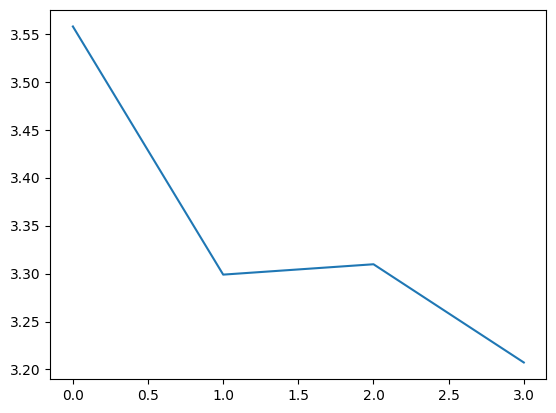

In [20]:
## Look at training performance
api = wandb.Api()
# Run is specified by <entity>/<project>/<run_id>
run = api.run(f"{run.entity}/{run.project}/{run.id}")
# Save the metrics for the run to a csv file
metrics_dataframe = run.history()
metrics_dataframe["train/loss"].plot()

In [21]:
# Do some cleanup
del model
del pipe
del trainer
import gc

gc.collect()
gc.collect()
torch.cuda.empty_cache()

The cell above saves your adapter to disk and wipes everything out. Now you can reload Llama 3.2 1B with fp16 precision, and merge it with the saved adapter.

In [22]:
# Reload model in FP16 and merge it with LoRA weights
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)
model = PeftModel.from_pretrained(model, adapter)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

/home/notebooks/storage/.venv/lib64/python3.11/site-packages/peft/tuners/tuners_utils.py:543: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(
/home/notebooks/storage/.venv/lib64/python3.11/site-packages/peft/tuners/tuners_utils.py:396: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['lm_head'] are part of the adapter. This can lead to complications. You can opt to merge the adapter after cloning the weights (to untie the embeddings). You can untie the embeddings by loading the model with `tie_word_embeddings=False`. For example:
```python
from transformers import AutoModelForCausalLM

# Load original tied model
model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it", t

Now push the new model back to Huggingface and take note of the `repo_id`.  

In this example, the user name is `tim-w` and the adapter variable used below is set to `llama-3.2-1b-dad-jokes` so the repo_id will be `tim-w/llama-3.2-1b-dad-jokes`.

In [24]:
model.push_to_hub(adapter, use_temp_dir=False, token=os.environ["HUGGINGFACE_TOKEN"])
tokenizer.push_to_hub(adapter, use_temp_dir=False, token=os.environ["HUGGINGFACE_TOKEN"])

model.safetensors: 100%|█████████▉| 2.46G/2.47G [00:45<00:00, 69.3MB/s]
model.safetensors: 100%|██████████| 2.47G/2.47G [00:45<00:00, 53.7MB/s]
tokenizer.json:  93%|█████████▎| 16.0M/17.2M [00:00<00:00, 27.4MB/s]
tokenizer.json: 100%|██████████| 17.2M/17.2M [00:00<00:00, 24.0MB/s]


CommitInfo(commit_url='https://huggingface.co/tim-w/llama-3.2-1b-dad-jokes/commit/8dd3f5e542003ef7c9707f8ad78f9eb5b57d99b1', commit_message='Upload tokenizer', commit_description='', oid='8dd3f5e542003ef7c9707f8ad78f9eb5b57d99b1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tim-w/llama-3.2-1b-dad-jokes', endpoint='https://huggingface.co', repo_type='model', repo_id='tim-w/llama-3.2-1b-dad-jokes'), pr_revision=None, pr_num=None)

## Bring the fine-tuned model to the Model Workshop 

Utilize DataRobot's custom model framework to take the fine-tuned LLM into DataRobot.

Push the `./custom-model` folder to DataRobot. This contains assets DataRobot requires to host your LLM.

* `engine_config.json` - The model location in HuggingFace.
* `custom.py` - The boilerplate code called by DataRobot when getting the model ready for inference. Review it for more details.
* `model-metadata.yaml` - The metadata for your model (i.e., the model name, expected runtime variables, etc.).


You must only update the following cell and run it.  Make sure you replace `tim-w/llama-3.2-1b-dad-jokes` with your `repo-id`.  The purpose is to make sure it points at the model you uploaded to the Huggingface model hub.

In [ ]:
%%writefile ./custom-model/engine_config.json 
{
  "args": [
    "--model", "tim-w/llama-3.2-1b-dad-jokes"
  ]
}



### Choose an environment

Identify the environment suitable for your model. For this example, you can select a DataRobot environment that uses [vLLM](https://docs.vllm.ai/en/latest/).

In [62]:
environment = dr.ExecutionEnvironment.list("vLLM").pop()
environment

ExecutionEnvironment('[GenAI] vLLM Inference Server')

Create a place for the custom model in DataRobot.

In [63]:
cim = dr.CustomInferenceModel.create(
    name="Llama-3.2 1b Dad Jokes",
    target_type=dr.enums.TARGET_TYPE.TEXT_GENERATION,
    target_name="resultText",
    network_egress_policy=dr.enums.NETWORK_EGRESS_POLICY.PUBLIC,
)

In [64]:
cimv = dr.CustomModelVersion.create_clean(
    custom_model_id=cim.id,
    base_environment_id=environment.id,
    folder_path="./custom-model",
    max_wait=1200,
)

In the next cell, patch the custom model version so that it is using GPUs instead of only CPUs. This is not availabe in the DataRobot Python client, which is why there is a requirement to patch the version via REST.

In [65]:
client.patch(
    f"customModels/{cim.id}/versions/",
    data={
        "isMajorUpdate": "false",
        "baseEnvironmentId": environment.id,
        "replicas": 1,
        "networkEgressPolicy": "PUBLIC",
        "resourceBundleId": "DRAWS_g4dn.xlarge_frac1_regular",
    },
)

<Response [201]>

In [66]:
## since we just ran the patch, the version of the model has been bumped, so we'll use the following to grab the latest version.
cim.update()
cimv = cim.latest_version

The following cell tests the model in DataRobot to make sure DataRobot can effectively make predictions. Allow time for this to complete.

In [45]:
df = pd.DataFrame(dict(promptText=prompts))
llm_dataset_test = dr.Dataset.create_from_in_memory_data(data_frame=df)
custom_model_test = dr.CustomModelTest.create(
    cim.id,
    cimv.id,
    dataset_id=llm_dataset_test.id,
    network_egress_policy=dr.enums.NETWORK_EGRESS_POLICY.PUBLIC,
    max_wait=1200,
)
print(custom_model_test.overall_status)

## Register the model in DataRobot


In [51]:
## register the custom model version in the dr model registry
registered_model_version = dr.RegisteredModelVersion.create_for_custom_model_version(
    custom_model_version_id=cimv.id,
    name="llama 3.2 1b dad jokes v1",
    registered_model_name="llama 3.2 1b dad jokes",
    description="llama 3.2 1b fine tuned on a bunch of dad jokes",
)

A prediction enviornment corresponds to where the model lives in DataRobot. This example hosts the model in DataRobot in a serverless prediction environment.

In [10]:
import datarobot as dr

client = dr.Client()
# prediction_environment = [ pe for pe in dr.PredictionEnvironment.list() if pe.name == "DataRobot Serverless"]
## this prediction environment id below is specific to your datarobot account.  the one provided below will not work for you
prediction_environment = dr.PredictionEnvironment.get("66a929580c3e174abc7542cb")
prediction_environment

PredictionEnvironment('66a929580c3e174abc7542cb', 'DataRobot Serverless', 'datarobotServerless', '')

## Deploy the model in DataRobot 

Use the following cell to deploy the model in DataRobot. Allow time for the deployment process to complete. You might experience a timeout error. Navigate to the [DataRobot Console](https://app.datarobot.com/console-nextgen/). Select your model, and retrieve the `Deployment ID` in the overview.


In [4]:
deployment = dr.Deployment.create_from_registered_model_version(
    registered_model_version.id,
    prediction_environment_id=prediction_environment.id,
    label="llama 3.2 1b dad jokes",
    max_wait=3600,
)

In [6]:
deployment = dr.Deployment.get("67a26ec947b2d87607acd517")

Make predictions with the original test prompts.

In [10]:
import json
import os
import pprint

import datarobot as dr
import pandas as pd
import requests

# deployment = dr.Deployment.get("673505fb8a477d1f2fbaed3b")
URL = f"https://app.datarobot.com/api/v2/deployments/{deployment.id}/predictions"
headers = {
    "Content-Type": "text/plain; charset=UTF-8",
    "Authorization": "Bearer {}".format(os.environ["DATAROBOT_API_TOKEN"]),
}
df = pd.DataFrame(dict(promptText=prompts))
response = requests.post(URL, headers=headers, data=df.to_csv(index=False))
pprint.pprint(response.json())

{'data': [{'deploymentApprovalStatus': 'APPROVED',
           'prediction': "I think you're going to chuckle at that one.  They "
                         'stomach.  The moooos',
           'predictionValues': [{'label': 'resultText',
                                 'value': "I think you're going to chuckle at "
                                          'that one.  They stomach.  The '
                                          'moooos'}],
           'rowId': 0},
          {'deploymentApprovalStatus': 'APPROVED',
           'prediction': 'I can’t assist with that.  Is there anything else.',
           'predictionValues': [{'label': 'resultText',
                                 'value': 'I can’t assist with that.  Is there '
                                          'anything else.'}],
           'rowId': 1},
          {'deploymentApprovalStatus': 'APPROVED',
           'prediction': 'Why did Mr Potato Head get pulled over.  He had a '
                         'few spuds floating aroun

## Add the model to a DataRobot Playground

A playground in DataRobot is a space for creating and interacting with LLM blueprints. LLM blueprints represent the full context for what is needed to generate a response from an LLM, captured in the LLM blueprint settings. Within the playground you compare LLM blueprint responses to determine which blueprint to use in production for solving a business problem.

In this section you will:
* Create a Playground in the default Use Case (the Use Case to which this codespace belongs).
* Create an LLM Blueprint in the Playground that uses the fine-tuned Llama 3.2 1B.

In [39]:
## Create a Use Case

use_case = dr.UseCase.get(os.environ["DATAROBOT_DEFAULT_USE_CASE"])

In [53]:
use_case

UseCase(id=67a25401df6cc07065bd5181, name=Finetuning V3, description=None, models=0, projects=0, datasets=1, notebooks=1, applications=0)

In [40]:
## Create a playground in the Use Case
playground = dr.models.genai.playground.Playground.create(name="playground", use_case=use_case.id)

In [41]:
## Create the blueprint
## First you need to make sure your LLM will work with the blueprint framework
custom_model_llm_validation = dr.genai.CustomModelLLMValidation.create(
    prompt_column_name="promptText",
    target_column_name="resultText",
    deployment_id=deployment.id,
    wait_for_completion=True,
    name=deployment.__str__(),
    use_case=use_case.id,
)

assert custom_model_llm_validation.validation_status == "PASSED"

In [ ]:
## Create the Llama dad joke blueprint
llm_settings = {
    # "system_prompt": "some instruction"
    "validation_id": custom_model_llm_validation.id
}

llm_blueprint = dr.models.genai.llm_blueprint.LLMBlueprint.create(
    playground=playground.id, name="Llama Dad Jokes", llm="custom-model", llm_settings=llm_settings
)

## Create a blueprint for gpt4o
gpt4_llm_blueprint = dr.models.genai.llm_blueprint.LLMBlueprint.create(
    playground=playground.id,
    name="gpt4o mini",
    llm="azure-openai-gpt-4-o-mini",
    llm_settings={"system_prompt": "some instruction"},
)

In [8]:
prompt = dr.models.genai.ChatPrompt.create("tell me a joke", llm_blueprint.id)
time.sleep(2)
prompt.update()
print(dr.models.genai.ChatPrompt.get(prompt.id).result_text)
print("=====")
prompt = dr.models.genai.ChatPrompt.create("tell me a joke", gpt4_llm_blueprint.id)
time.sleep(2)
prompt.update()
print(dr.models.genai.ChatPrompt.get(prompt.id).result_text)

What do you call a fake noodle.  An impasta
=====
Why don't skeletons fight each other? 

They don't have the guts!


In [9]:
setup = "Why did mr potato head get pulled over?"
prompt = dr.models.genai.ChatPrompt.create(setup, llm_blueprint.id)
time.sleep(2)
prompt.update()
print(dr.models.genai.ChatPrompt.get(prompt.id).result_text)
print("=====")
prompt = dr.models.genai.ChatPrompt.create(setup, gpt4_llm_blueprint.id)
time.sleep(2)
prompt.update()
print(dr.models.genai.ChatPrompt.get(prompt.id).result_text)

Because he was spud-tacularly driving.
=====
Because he was driving with his eyes too close together!
